In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

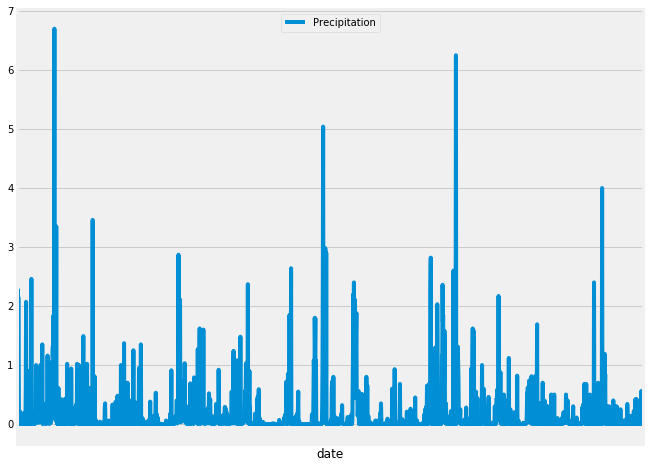

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date
yr_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
yr_ago



# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23', Measurement.date <= '2017-08-23').\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp).dropna()
df.set_index('date', inplace=True)
df.rename(columns = {'prcp': 'precipitation'})


# Sort the dataframe by date
# query ordered by date already. AH

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,8))
plt.legend(["Precipitation"], loc="upper center")
plt.xticks([])
plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
station = session.query(Measurement.station).group_by(Measurement.station).count()
station

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station,func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).first()

list_station = session.query(Measurement.station,func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
list_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                    filter(Measurement.station== most_active_station.station).all()
temp

[(54.0, 85.0, 71.66378066378067)]

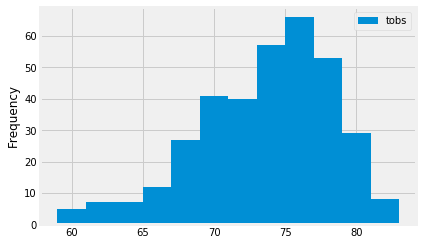

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(Measurement.tobs).\
                                filter(Measurement.station== most_active_station.station).\
                                filter(Measurement.date >= yr_ago).\
                                order_by(Measurement.date.desc()).all()

temp_df = pd.DataFrame(histogram)
temp_df

temp_df.plot.hist(bins=12)
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-01-01'
end_date = '2017-01-05'
trip = calc_temps(start_date, end_date)
trip

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=['TMIN', 'TAVG', 'TMAX'])
avg_temp = trip_df['TAVG']
peak_to_peak = trip_df.iloc[0]['TMAX'] - trip_df.iloc[0]['TMIN']
avg_temp.plot(kind='bar', yerr=peak_to_peak, figsize=(6,8), alpha=0.5, color = 'coral')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.show()


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall= session.query(Measurement.station,
                         Station.name,
                         Measurement.prcp.label('total amt of rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by(Measurement.prcp).all()
rainfall

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals= []

# Set the start and end date of the trip
start_date = '1/1/2018' 
end_date= '1/5/2018'

# Use the start and end date to create a range of dates
trip_range = pd.date_range(start=start_date, end=end_date)
trip_range

# # Stip off the year and save a list of %m-%d strings
mmdd = trip_range.strftime('%m-%d')
mmdd

# # Loop through the list of %m-%d strings and calculate the normals for each date
for date in mmdd:
    normals.append(*daily_normals(date))
normals


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
normals_df['date']= trip_range
normals_df.set_index('date')


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area',x='date',stacked=False)

In [20]:
prcpdata = session.query(Measurement.date, Measurement.prcp).all()

precipitation = []
for date, prcp in prcpdata:
    precipitation_dict = {}
    precipitation_dict["date"] = date
    precipitation_dict["prcp"] = prcp
    precipitation.append(precipitation_dict)

precipitation


[{'date': '2010-01-01', 'prcp': 0.08},
 {'date': '2010-01-02', 'prcp': 0.0},
 {'date': '2010-01-03', 'prcp': 0.0},
 {'date': '2010-01-04', 'prcp': 0.0},
 {'date': '2010-01-06', 'prcp': None},
 {'date': '2010-01-07', 'prcp': 0.06},
 {'date': '2010-01-08', 'prcp': 0.0},
 {'date': '2010-01-09', 'prcp': 0.0},
 {'date': '2010-01-10', 'prcp': 0.0},
 {'date': '2010-01-11', 'prcp': 0.01},
 {'date': '2010-01-12', 'prcp': 0.0},
 {'date': '2010-01-14', 'prcp': 0.0},
 {'date': '2010-01-15', 'prcp': 0.0},
 {'date': '2010-01-16', 'prcp': 0.0},
 {'date': '2010-01-17', 'prcp': 0.0},
 {'date': '2010-01-18', 'prcp': 0.0},
 {'date': '2010-01-19', 'prcp': 0.0},
 {'date': '2010-01-20', 'prcp': 0.0},
 {'date': '2010-01-21', 'prcp': 0.0},
 {'date': '2010-01-22', 'prcp': 0.0},
 {'date': '2010-01-23', 'prcp': 0.0},
 {'date': '2010-01-24', 'prcp': 0.01},
 {'date': '2010-01-25', 'prcp': 0.0},
 {'date': '2010-01-26', 'prcp': 0.04},
 {'date': '2010-01-27', 'prcp': 0.12},
 {'date': '2010-01-28', 'prcp': 0.0},
 {'da

In [21]:
list_station = session.query(Station.station).all()

list_station

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [23]:
histogram = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
                filter(Measurement.date > '2016-08-23', Measurement.date <= '2017-08-23').\
                order_by(Measurement.date).all()
date_temp = []
for station, date, tobs in histogram:
    tobs_dict ={}
    tobs_dict["Station"]=station
    tobs_dict["Date"]=date
    tobs_dict["tobs"]= tobs
    date_temp.append(tobs_dict)

date_temp

[{'Station': 'USC00519397', 'Date': '2016-08-24', 'tobs': 79.0},
 {'Station': 'USC00513117', 'Date': '2016-08-24', 'tobs': 76.0},
 {'Station': 'USC00514830', 'Date': '2016-08-24', 'tobs': 80.0},
 {'Station': 'USC00517948', 'Date': '2016-08-24', 'tobs': 78.0},
 {'Station': 'USC00519523', 'Date': '2016-08-24', 'tobs': 79.0},
 {'Station': 'USC00519281', 'Date': '2016-08-24', 'tobs': 77.0},
 {'Station': 'USC00516128', 'Date': '2016-08-24', 'tobs': 74.0},
 {'Station': 'USC00519397', 'Date': '2016-08-25', 'tobs': 80.0},
 {'Station': 'USC00513117', 'Date': '2016-08-25', 'tobs': 77.0},
 {'Station': 'USC00514830', 'Date': '2016-08-25', 'tobs': 81.0},
 {'Station': 'USC00517948', 'Date': '2016-08-25', 'tobs': 81.0},
 {'Station': 'USC00519523', 'Date': '2016-08-25', 'tobs': 80.0},
 {'Station': 'USC00519281', 'Date': '2016-08-25', 'tobs': 80.0},
 {'Station': 'USC00516128', 'Date': '2016-08-25', 'tobs': 77.0},
 {'Station': 'USC00519397', 'Date': '2016-08-26', 'tobs': 79.0},
 {'Station': 'USC00513117

In [24]:
start_date = '2017-01-01'
end_date = '2017-01-05'
start_tob = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date, Measurement.date <= '2017-08-23').all()
start_tob

[(58.0, 74.14387974230493, 87.0)]

In [25]:
start_end_tob = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date, Measurement.date <= end_date).all()
start_end_tob

[(62.0, 68.13793103448276, 74.0)]